## Presidential logorrhea
Analyze the lengths of the State of the Union Addresses.

In [4]:
from pyspark.sql import SparkSession

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')
print type(df)
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+----+
|           president|                text|year|
+--------------------+--------------------+----+
|        James Monroe| Fellow-Citizens ...|1821|
|    William McKinley| To the Senate an...|1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|
|     Calvin Coolidge|Since the close o...|1923|
|       James Madison| Fellow-Citizens ...|1816|
|    Grover Cleveland| To the Congress ...|1886|
|   John Quincy Adams| Fellow Citizens ...|1827|
|  Theodore Roosevelt| To the Senate an...|1905|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|
|       James K. Polk| Fellow-Citizens ...|1848|
|      Woodrow Wilson|Gentlemen of the ...|1913|
|Dwight D. Eisenhower|[Delivered in per...|1955|
|         George Bush|Mr. President and...|1991|
|     Franklin Pierce| Fellow-Citizens ...|1856|
...|1944| D. Roose...|To the Congress:
|   Lyndon B. Johnson|[Delivered in per...|1968|
|      Andrew Johnson| Fellow-Citizen

In [74]:
import re
from __future__ import division
def parse_data(x):
    #replace 'Mr.' by 'Mr' and etc. for a more accurate parse of sentence 
    x = x.replace('Mr.', 'Mr')\
            .replace('Mrs.', 'Mrs')\
            .replace('Ms.', 'Ms')\
            .replace('Miss.', 'Miss')\
            .replace('Prof.', 'Prof')\
            .replace('St.', 'St')\
            .replace('Dr.', 'Dr')
    pattern = re.compile(r'([A-Z][^\.!?]*[\.!?])', re.MULTILINE | re.DOTALL)
    sentences = pattern.findall(x)
    sen_num = len(sentences)
    words =[len(sentence.strip().split(' ')) for sentence in sentences]
    word_num = sum(words)
    min_sen_len = min(words)
    max_sen_len = max(words)
    return (sen_num, word_num, word_num / sen_num, min_sen_len, max_sen_len)


In [75]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
df_clean = df.rdd.map(lambda x: (x['president'], int(x['year']), parse_data(x['text']))).cache()
ex = df_clean.take(10)
print 15 * ' ' + 'President' + 4 * ' ' + 'Year' + 4 * ' ' + 'word#' + 4 * ' ' + '#sentence' + 4*' ' + 'Ave_sen_len'
for x in ex:
    print '%25s %6d %7d %10d\t\t%.02f\n%s' % (x[0], x[1], x[2][1], x[2][0], x[2][2], 80 * '-')
    
data = np.array(df_clean.map(lambda x: (x[0], x[1], x[2][0], x[2][1], x[2][2])).collect()).T
year = data[1,:].astype(int)
sen_len = data[2,:].astype(int)
word_len = data[3,:].astype(int)
ave_sen_len = data[4,:].astype(float)



               President    Year    word#    #sentence    Ave_sen_len
             James Monroe   1821    5712        153		37.33
--------------------------------------------------------------------------------
         William McKinley   1897   12100        376		32.18
--------------------------------------------------------------------------------
     Dwight D. Eisenhower   1960    5590        254		22.01
--------------------------------------------------------------------------------
          Calvin Coolidge   1923    6663        362		18.41
--------------------------------------------------------------------------------
            James Madison   1816    3361         72		46.68
--------------------------------------------------------------------------------
         Grover Cleveland   1886   14953        419		35.69
--------------------------------------------------------------------------------
        John Quincy Adams   1827    6919        164		42.19
-------------------------------

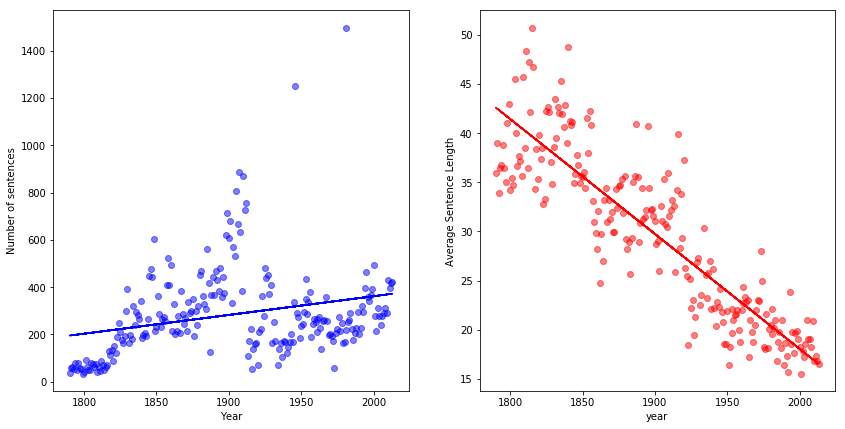

In [49]:
def lr(x0, y0):
    #Linear regression
    x = np.vstack([x0, np.ones(len(x0))])
    beta = np.linalg.solve(np.dot(x, x.T), np.dot(x, y0))
    yhat = np.dot(x.T, beta)
    return yhat

plt.figure(figsize = (14,7))
plt.subplot(1,2,1)
plt.plot(year, sen_len, 'bo', alpha = 0.5)
plt.plot(year, lr(year, sen_len), c = 'b')
plt.xlabel('Year')
plt.ylabel('Number of sentences')
plt.subplot(1,2,2)
plt.plot(year, ave_sen_len, 'ro', alpha = 0.5)
plt.plot(year, lr(year, ave_sen_len), c = 'r')
plt.xlabel('Year')
plt.ylabel('Average Sentence Length')
plt.show()

The number of sentences increases and the average sentence length decreases by year. 

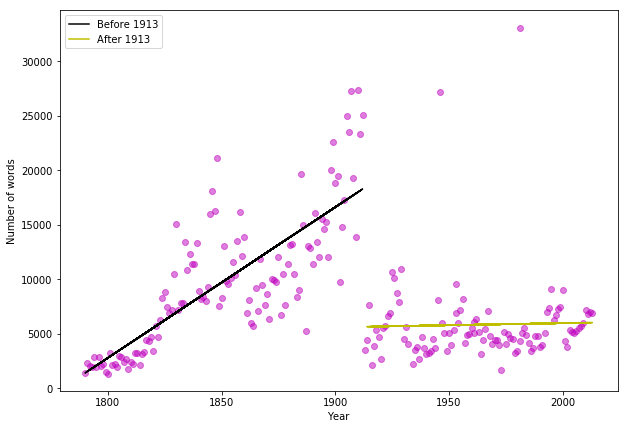

In [59]:
early = np.where(year <= 1912)
late = np.where(year > 1913)
plt.figure(figsize = (10, 7))
plt.plot(year, word_len, 'mo', alpha = 0.5)
plt.plot(year[early], lr(year[early], word_len[early]), c = 'k', label = 'Before 1913')
plt.legend()
plt.plot(year[late], lr(year[late], word_len[late]), c = 'y', label = 'After 1913')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of words')
plt.show()


Before 1913, the number of words increases 139.150978 per year to around 20000. After 1913, the word number is averaged around 5856 with small increase of word numbers around 5.567441 by year.
George Washington delivered the first regular annual message before a joint session of Congress on January 8, 1790, in New York City, then the provisional U.S. capital. In 1801, Thomas Jefferson discontinued the practice of delivering the address in person, regarding it as too monarchical (similar to the Speech from the Throne). Instead, the address was written and then sent to Congress to be read by a clerk until 1913 when Woodrow Wilson re-established the practice despite some initial controversy. 

In [66]:
from scipy import stats
def ave(x):
    #average sentence length by president
    a, b = 0, 0
    for xi in x:
        a += xi[0]
        b += xi[1]
    return b/a

sen_len_president = df_clean.map(lambda x: (x[0], (x[2][0], x[2][1]))).groupByKey().mapValues(ave).cache()
max_president = sen_len_president.max(lambda x: x[1])
min_president = sen_len_president.min(lambda x: x[1])
print max_president[0], 'has the longest sentences with the average length:', max_president[1]
print min_president[0], 'has the shortest sentences with the average length:', min_president[1]

sen_len_president_all = sen_len_president.map(lambda x: x[1]).collect()
print '\n\n' + 10 * ' ' + 'The statistics of sentence length for each president' + '\n' + 70 * '-'
print '%10s %10s %10s %10s %10s %10s' % ('min', '25Q', 'mean', 'median', '75Q', 'max')
print '%10.2f %10.2f %10.2f %10.2f %10.2f %10.2f' %(
    np.min(sen_len_president_all),
    np.percentile(sen_len_president_all, 25),
    np.mean(sen_len_president_all),
    np.median(sen_len_president_all),
    np.percentile(sen_len_president_all, 75),
    np.max(sen_len_president_all),
)


James Madison has the longest sentences with the average length: 43.9695121951
George Bush has the shortest sentences with the average length: 16.8309455587


          The statistics of sentence length for each president
----------------------------------------------------------------------
       min        25Q       mean     median        75Q        max
     16.83      21.47      29.67      31.42      35.61      43.97


In [73]:
sen_len_min = df_clean.map(lambda x: (x[0], x[2][3])).min(key = lambda x: x[1])
sen_len_max = df_clean.map(lambda x: (x[0], x[2][4])).max(key = lambda x: x[1])

print '%s spoke the shortest sentence, the length of which is %d.\n' % (sen_len_min[0], sen_len_min[1])
print '%s spoke the longest sentence, the length of which is %d.\n' % (sen_len_max[0], sen_len_max[1])


William McKinley spoke the shortest sentence, the length of which is 1.

Jimmy Carter spoke the longest sentence, the length of which is 608.



In [76]:
spark.stop()